# Setup for Figure S5A (right), B (right), D, G-H, I, J (Split Maze)

Note exact results for K-Means and decoder based analyses will change slightly each time. As a result, exact statistics here may not match the manuscript text but should recapitulate results.

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def circ_autocorr(x):
    Fx = np.fft.fft(x)
    Fxp = np.conj(np.fft.fft(x))
    return np.roll(np.fft.ifft(Fx * Fxp).real, x.size // 2)

def ar1_acf(nt, phi, sigma2):
    """
    Computes the theoretical autocorrelation function for an AR(1) model.
    This serves as our null distribution for computing significance
    
    Params:
    -------
    nt : number of timesteps
    phi : autoregressive coefficient
    sigma2 : variance of gaussian noise
    """
    return (phi ** np.arange(nt)) * sigma2 / (1 - phi ** 2)

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [4]:
''' Load Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/LocalData/animalmeta.csv')
animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,...,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions,Total_Cells,visualacuity,perchangespeedgain,perchangekurt,perchangeskew,perchangeIQR
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,...,645,3,6,6,1540.0,NaN,17.367862,NaN,NaN,NaN
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,...,645,3,6,6,1574.0,NaN,22.050636,NaN,NaN,NaN
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,...,714,3,6,6,1002.0,NaN,21.328531,NaN,NaN,NaN
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,...,714,3,6,6,985.0,NaN,15.687094,NaN,NaN,NaN
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,...,691,3,6,6,1691.0,NaN,52.102357,NaN,NaN,NaN


In [5]:
'''Find names of specific animals groups'''
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

In [6]:
''' Complete List of Mice & Sessions for Neural Data '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [7]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [8]:
''' Find & save indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/indices/'


for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #define indices for first two quarters accounting for skipped trials
        start_idx = (np.where(trial >= 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        enda_idx = (np.where(trial <= 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        endb_idx = (np.where(trial <= 139)[0][-1]).astype(int) # last index before alternation
        Aidx = np.arange(start_idx, enda_idx + 1, 1)
        Bidx = np.arange(enda_idx + 1, endb_idx + 1, 1)
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
    
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        A_idx = []
        for t in A_trials:
            A_idx = np.append(A_idx, np.where(trial == t)[0])
            A_idx = A_idx.astype(int)
            
        B_idx = []
        for t in B_trials:
            B_idx = np.append(B_idx, np.where(trial == t)[0])
            B_idx = B_idx.astype(int)
            
        #save indices for session section
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
                
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            continue 
            
        #get count of gain in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        A_ngidx = np.setdiff1d(A_idx,Agidx).astype(int)
        B_ngidx = np.setdiff1d(B_idx,Bgidx).astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        

  0%|          | 0/3 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[ 6  7 83]
Skipped trials, n skipped = 11[ 39  40  41  74  75  76  77  78 108 127 180]
Skipped trials, n skipped = 1[160]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 1[168]
Skipped trials, n skipped = 1[130]
Skipped trials, n skipped = 2[ 29 144]
Skipped trials, n skipped = 4[161 164 165 166]


  0%|          | 0/4 [00:00<?, ?it/s]

Skipped trials, n skipped = 15[100 101 102 110 111 112 113 114 115 116 117 118 119 172 181]
Skipped trials, n skipped = 4[141 188 189 190]
Skipped trials, n skipped = 11[ 82 109 110 130 149 150 157 169 170 178 179]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 1[167]
Skipped trials, n skipped = 9[185 186 187 188 189 190 191 192 193]
Skipped trials, n skipped = 5[108 109 110 111 208]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 4[  5  87  88 100]
Skipped trials, n skipped = 1[132]
Skipped trials, n skipped = 4[177 178 179 180]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20013123_record6 did not reach gain change


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[120 121 122]
Skipped trials, n skipped = 3[127 128 143]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[169 170 171]
Skipped trials, n skipped = 23[105 106 107 108 109 110 111 112 113 114 138 139 140 141 142 143 144 145
 146 147 148 188 189]
Skipped trials, n skipped = 1[22]
Skipped trials, n skipped = 2[166 178]
Skipped trials, n skipped = 2[175 202]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 1[144]
Skipped trials, n skipped = 1[212]
Skipped trials, n skipped = 2[115 152]
Skipped trials, n skipped = 3[ 21 161 177]


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 2[137 138]
Skipped trials, n skipped = 2[ 52 167]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
''' Generate behavioral data for alternation'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
         # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            
        
#Find & Save Number of Missed Rewards per Session & Animal
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            # print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            # print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        d['altreqbytrial'] = requests[alt_idx]
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

blocksatiety = np.asarray(blocksatiety)
blockreq = np.asarray(blockreq)
blocktrialn = np.asarray(blocktrialn)

Skipped & dark trials omitted from reward data, n skipped = 3
Mouse A14 with n_misses: 183
got lick indices for mouse A14 session 083022_record1
got reward indices for mouse A14 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 11
Mouse A14 with n_misses: 154
got lick indices for mouse A14 session 083122_record2
got reward indices for mouse A14 session 083122_record2
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A14 with n_misses: 145
got lick indices for mouse A14 session 090122_record3
got reward indices for mouse A14 session 090122_record3
No trials skipped; only dark trials omitted from reward data
Mouse A15 with n_misses: 105
got lick indices for mouse A15 session 083022_record1
got reward indices for mouse A15 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A15 with n_misses: 80
got lick indices for mouse A15 session 083122_record2
got reward indices for mouse A15 session 083122_reco

No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 104
got lick indices for mouse A22 session 020223_record6
got reward indices for mouse A22 session 020223_record6
No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 84
got lick indices for mouse A22 session 020323_record7
got reward indices for mouse A22 session 020323_record7
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 141
got lick indices for mouse A23 session 020923_record1
got reward indices for mouse A23 session 020923_record1
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 102
got lick indices for mouse A23 session 021023_record2
got reward indices for mouse A23 session 021023_record2
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 52
got lick indices for mouse A23 session 021123_record3
got reward indices for mouse A23 session 021123_record3
No

No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 46
got lick indices for mouse MA4M session 110322_record5rep
got reward indices for mouse MA4M session 110322_record5rep
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 15
got lick indices for mouse MA4M session 110422_record6
got reward indices for mouse MA4M session 110422_record6
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 116
got lick indices for mouse MA4M session 110522_record7
got reward indices for mouse MA4M session 110522_record7
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 98
got lick indices for mouse MA5M session 110622_record1
got reward indices for mouse MA5M session 110622_record1
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 89
got lick indices for mouse MA5M session 110722_record2
got reward indices for mouse MA5M sessio

No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 8
got lick indices for mouse Y21 session 092222_record5
got reward indices for mouse Y21 session 092222_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 4
got lick indices for mouse Y21 session 092322_record6
got reward indices for mouse Y21 session 092322_record6
Skipped & dark trials omitted from reward data, n skipped = 3
Mouse Y22 with n_misses: 134
got lick indices for mouse Y22 session 092522_record1
got reward indices for mouse Y22 session 092522_record1
Skipped & dark trials omitted from reward data, n skipped = 23
Mouse Y22 with n_misses: 49
got lick indices for mouse Y22 session 092622_record2
got reward indices for mouse Y22 session 092622_record2
No trials skipped; only dark trials omitted from reward data
Mouse Y22 with n_misses: 24
got lick indices for mouse Y22 session 092722_record3
got reward indices for mouse Y22 session 092722_record3
Ski

No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 42
got lick indices for mouse Y28 session 030223_record5
got reward indices for mouse Y28 session 030223_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 36
got lick indices for mouse Y28 session 030323_record6
got reward indices for mouse Y28 session 030323_record6


In [10]:
''' Load spatial cell (Figure 2/S3) and intn (Shuffle Procedure) booleans generated by previous notebooks. '''

#adjujst paths
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell99'] = np.load(save_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
''' Apply FR thresholds to spatial cells

Run time < 1 min / session (167 sessions)

'''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

#adjust paths
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/'

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        intn = d['intn']
        
        #define low FR cell group (mean FR <0.05 in the dark; 0.3 Hz overall); to be removed from grid cell group
        stop_idx = np.where(trial <= 19)[0][-1].astype(int)
        darkFR, _ , _ = ps.tuning_curve_bytrial(posxfil[:stop_idx], trial[:stop_idx], Y[:stop_idx,:], dt, b = 2, smooth=True, normalize=False, occupancy=True)
        FR, _, _ = ps.tuning_curve(posxfil, Y, dt, b, smooth=True, l=2, SEM=False, occupancy=False)
        lowfrcells = []
        lowdarkfrcells = []
        for i, c in enumerate(cell_IDs):
            if np.mean(np.mean(darkFR[:,:,i], axis = 1)) <= 0.05:
                lowdarkfrcells = np.append(lowdarkfrcells, c)
            elif np.mean(FR[:,i]) < 0.3:
                lowfrcells = np.append(lowfrcells, c)      
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):
            #also require that dark FR > 0.05 Hz and mean FR > 0.3 Hz
            if (c in lowfrcells) or (c in lowdarkfrcells):
                spatialcell99[i] = 0
                
            if (c in noisycells):
                spatialcell99[i] = 0
                spatialcell99[i] = 0
                
        #Save booleans
        spatialcell99 = spatialcell99.astype(bool)
        d['spatialcell99'] = spatialcell99

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
''' Load saved spatial cell booleans & glance at overall density '''

save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'

perspatial = []
sperspatial = []
mperspatial = []

for m, session in zip(mice,sessions):
    
    m_perspatial = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        spatialcell = d['spatialcell99'].astype(bool)
        
        print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        perspatial = np.append(perspatial, 100*np.sum(spatialcell)/len(cell_IDs))        
        sperspatial = np.append(sperspatial, 100*np.sum(spatialcell)/len(cell_IDs))
        m_perspatial = np.append(m_perspatial, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
    
    mperspatial = np.append(mperspatial, np.sum(m_perspatial)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n spatial cells: 67
A14, 083122_record2 n spatial cells: 4
A14, 090122_record3 n spatial cells: 24


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n spatial cells: 10
A15, 083122_record2 n spatial cells: 116
A15, 090122_record3 n spatial cells: 128
A15, 090222_record4 n spatial cells: 182
A15, 090322_record5 n spatial cells: 74
A15, 090422_record6 n spatial cells: 40


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n spatial cells: 44
A16, 083122_record2 n spatial cells: 93
A16, 090122_record3 n spatial cells: 4
A16, 090222_record4 n spatial cells: 52


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n spatial cells: 3
A17, 082422_record2 n spatial cells: 6
A17, 082522_record3 n spatial cells: 71
A17, 082622_record4 n spatial cells: 58
A17, 082722_record5 n spatial cells: 40
A17, 082822_record6 n spatial cells: 72


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n spatial cells: 30
A18, 082422_record2 n spatial cells: 229
A18, 082522_record3 n spatial cells: 198
A18, 082622_record4 n spatial cells: 113
A18, 082722_record5 n spatial cells: 59
A18, 082822_record6 n spatial cells: 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n spatial cells: 1
A19, 012823_record3 n spatial cells: 106
A19, 012923_record4 n spatial cells: 116
A19, 013023_record5 n spatial cells: 91
A19, 013123_record6 n spatial cells: 65
A19, 020123_record7 n spatial cells: 81


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n spatial cells: 25
A20, 012723_record2 n spatial cells: 72
A20, 012823_record3 n spatial cells: 117
A20, 012923_record4 n spatial cells: 59
A20, 013023_record5 n spatial cells: 75
A20, 013123_record6 n spatial cells: 41


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n spatial cells: 95
A22, 013023_record3 n spatial cells: 192
A22, 013123_record4 n spatial cells: 96
A22, 020123_record5 n spatial cells: 20
A22, 020223_record6 n spatial cells: 68
A22, 020323_record7 n spatial cells: 17


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n spatial cells: 13
A23, 021023_record2 n spatial cells: 85
A23, 021123_record3 n spatial cells: 89
A23, 021223_record4 n spatial cells: 10
A23, 021323_record5 n spatial cells: 64
A23, 021423_record6 n spatial cells: 103


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n spatial cells: 91
A24, 022723_record2 n spatial cells: 189
A24, 022823_record3 n spatial cells: 122
A24, 030123_record4 n spatial cells: 100
A24, 030223_record5 n spatial cells: 81
A24, 030323_record6 n spatial cells: 37


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n spatial cells: 142
MA10F, 111422_record2 n spatial cells: 93
MA10F, 111522_record3 n spatial cells: 59
MA10F, 111622_record4 n spatial cells: 41
MA10F, 111722_record5 n spatial cells: 38
MA10F, 111822_record6 n spatial cells: 85


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n spatial cells: 54
MA1F, 102422_record2 n spatial cells: 79
MA1F, 102522_record3 n spatial cells: 75
MA1F, 102622_record4 n spatial cells: 19
MA1F, 102722_record5 n spatial cells: 117
MA1F, 102822_record6 n spatial cells: 100


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n spatial cells: 112
MA2F, 102422_record2 n spatial cells: 128
MA2F, 102522_record3 n spatial cells: 146
MA2F, 102622_record4 n spatial cells: 102
MA2F, 102722_record5 n spatial cells: 73
MA2F, 102822_record6 n spatial cells: 85


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n spatial cells: 25
MA3M, 102422_record2 n spatial cells: 96
MA3M, 102522_record3 n spatial cells: 64
MA3M, 102622_record4 n spatial cells: 68
MA3M, 102722_record5 n spatial cells: 40
MA3M, 102822_record6 n spatial cells: 67


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n spatial cells: 91
MA4M, 110122_record3 n spatial cells: 54
MA4M, 110222_record4 n spatial cells: 19
MA4M, 110322_record5rep n spatial cells: 43
MA4M, 110422_record6 n spatial cells: 51
MA4M, 110522_record7 n spatial cells: 17


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n spatial cells: 78
MA5M, 110722_record2 n spatial cells: 138
MA5M, 110822_record3 n spatial cells: 124
MA5M, 110922_record4 n spatial cells: 21
MA5M, 111022_record5 n spatial cells: 44
MA5M, 111122_record6 n spatial cells: 42


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n spatial cells: 94
MA6M, 103122_record2 n spatial cells: 68
MA6M, 110122_record3 n spatial cells: 124
MA6M, 110222_record4 n spatial cells: 26
MA6M, 110322_record5 n spatial cells: 21
MA6M, 110422_record6 n spatial cells: 68


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n spatial cells: 61
MA7M, 103122_record2 n spatial cells: 86
MA7M, 110122_record3 n spatial cells: 57
MA7M, 110222_record4 n spatial cells: 11


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n spatial cells: 27
MA8F, 111422_record2 n spatial cells: 118
MA8F, 111522_record3 n spatial cells: 111
MA8F, 111622_record4 n spatial cells: 61
MA8F, 111722_record5 n spatial cells: 41
MA8F, 111822_record6 n spatial cells: 29


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n spatial cells: 74
MA9F, 111422_record2 n spatial cells: 220
MA9F, 111522_record3 n spatial cells: 164
MA9F, 111622_record4 n spatial cells: 1
MA9F, 111722_record5 n spatial cells: 49
MA9F, 111822_record6 n spatial cells: 38


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n spatial cells: 15
Y20, 092622_record2 n spatial cells: 68
Y20, 092722_record3 n spatial cells: 21
Y20, 092822_record4 n spatial cells: 82
Y20, 092922_record5 n spatial cells: 33
Y20, 093022_record6 n spatial cells: 160


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n spatial cells: 163
Y21, 091922_record2 n spatial cells: 169
Y21, 092022_record3 n spatial cells: 62
Y21, 092122_record4 n spatial cells: 111
Y21, 092222_record5 n spatial cells: 75
Y21, 092322_record6 n spatial cells: 26


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n spatial cells: 136
Y22, 092622_record2 n spatial cells: 200
Y22, 092722_record3 n spatial cells: 156
Y22, 092822_record4 n spatial cells: 44
Y22, 092922_record5 n spatial cells: 47
Y22, 093022_record6 n spatial cells: 91


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n spatial cells: 51
Y23, 092622_record2 n spatial cells: 38
Y23, 092722_record3 n spatial cells: 64
Y23, 092822_record4 n spatial cells: 59
Y23, 092922_record5 n spatial cells: 91
Y23, 093022_record6 n spatial cells: 132


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n spatial cells: 150
Y24, 091922_record2 n spatial cells: 86
Y24, 092022_record3 n spatial cells: 137
Y24, 092122_record4 n spatial cells: 149
Y24, 092222_record5 n spatial cells: 125
Y24, 092322_record6 n spatial cells: 123


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n spatial cells: 1
Y25, 021723_record2 n spatial cells: 117
Y25, 021823_record3 n spatial cells: 89
Y25, 021923_record4 n spatial cells: 78
Y25, 022023_record5 n spatial cells: 83
Y25, 022123_record6 n spatial cells: 25


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n spatial cells: 79
Y26, 021723_record2 n spatial cells: 83
Y26, 021823_record3 n spatial cells: 51
Y26, 021923_record4 n spatial cells: 3
Y26, 022023_record5 n spatial cells: 35
Y26, 022123_record6 n spatial cells: 6


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n spatial cells: 94
Y27, 021723_record2 n spatial cells: 57
Y27, 021823_record3 n spatial cells: 53
Y27, 021923_record4 n spatial cells: 35
Y27, 022023_record5rep n spatial cells: 71
Y27, 022123_record6 n spatial cells: 94


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n spatial cells: 35
Y28, 022723_record2 n spatial cells: 85
Y28, 022823_record3 n spatial cells: 73
Y28, 030123_record4 n spatial cells: 49
Y28, 030223_record5 n spatial cells: 114
Y28, 030323_record6 n spatial cells: 89


Mean, SEM Spatial Cell %
29.15809617608128 0.9674108723859292


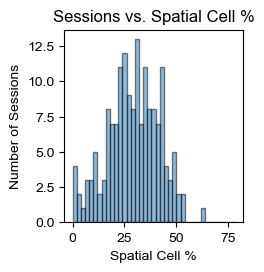

In [13]:
''' Examine spatial cell densities quickly as a sanity check'''

# Assess distribution of spatial/ngs cell densities
print('Mean, SEM Spatial Cell %')
print(np.mean(perspatial), stats.sem(perspatial))

#plot spatial cell % distributions
fig, ax = plt.subplots(1,1,figsize = (2.3,2.5), sharey = True)
ax.hist(perspatial, bins = np.arange(0,80,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax.set_title('Sessions vs. Spatial Cell %')
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Spatial Cell %')

plt.show()

In [14]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'

age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [15]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Load computed Spatial FR Tensor

In [16]:
''' Load Sorted Normalized FR Tensor for Grid Network in Back of Track, excluding Gain Change Period '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
         
        VRbackidx_file = 'VRbackidx_' + m + '_' + s + '.npy'
        VRbackidx = np.load(save_folder + VRbackidx_file)
        d['VRbackidx'] = VRbackidx
        
        skippedrawtrialfil_file = 'skippedrawtrialfil_' + m + '_' + s + '.npy'
        skippedrawtrialfil = np.load(save_folder + skippedrawtrialfil_file)
        d['skippedrawtrialfil'] = skippedrawtrialfil
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]     
        
        if len(spatialcells) > 10:
            #load grid network FR tensor 
            FRtensor_file = 'SM_spatialFRtensorbacksorted_' + m + '_' + s + '.npy'
            normspatialFR = np.load(save_folder + FRtensor_file)
            d['spatialFRtensorbacksorted'] = normspatialFR 
            
            #get grid network trial by trial sim matrix 
            normspatialFR_unwrapped = np.reshape(normspatialFR, (normspatialFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialFR_unwrapped, 'correlation')-1)
            sim = squareform(sim_vec)  
            d['spatialsimilaritybacksorted'] = sim
        else:
            print('too few spatial cells in session: ' + str(m) + ', ' + str(s))

  0%|          | 0/3 [00:00<?, ?it/s]

too few spatial cells in session: A14, 083122_record2


  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: A15, 083022_record1


  0%|          | 0/4 [00:00<?, ?it/s]

too few spatial cells in session: A16, 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: A17, 082322_record1
too few spatial cells in session: A17, 082422_record2


  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: A18, 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: A19, 012723_record2


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: A23, 021223_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: MA9F, 111622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: Y25, 021623_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few spatial cells in session: Y26, 021923_record4
too few spatial cells in session: Y26, 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Load results of k optimization code in Figure 3 & S4 notebook. 

In [17]:
''' Load in KMeans '''

from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from lvl.resamplers import RotationResampler
from lvl.crossval import speckled_cv_scores 
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
from sklearn.metrics import silhouette_samples, silhouette_score

def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [16]:
''' After k optimization, load in results & perform K-means '''

kmeans_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/kmeans/spatial/' #adjust path to output above this 

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]     
        
        if len(spatialcells) > 10: 
            
            #Load stuff I have saved previously
            SilN_file = 'SilN_' + m + '_' + s + '.npy'
            SilN = np.load(kmeans_folder + SilN_file)
            
            #fit K-means
            Y = d['spatialFRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
            model_kmeans.fit(Y_unwrapped)
            W, H = model_kmeans.factors
            Y_hat = model_kmeans.predict()
            score = model_kmeans.score(Y_unwrapped)
            d['kmeans'] = {}
            d['kmeans']['SilN'] = SilN
            d['kmeans']['W'] = W
            d['kmeans']['H'] = H
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['score'] = score
            
            #load boolean to determine if I should keep k-means map in dataset (better than shuffle at chosen k)
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(kmeans_folder + onemapfile)
            d['kmeans']['onemap'] = onemap

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'ax' is not defined

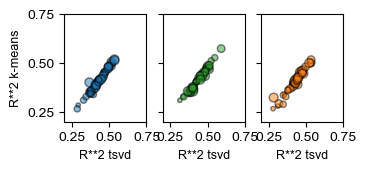

In [17]:
''' Gather the relative performance of K-Means vs. TSVD at Optimal K

Run time: ~30 - 45 seconds / session x 167 sessions

'''

from lvl.factor_models import TSVD
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/kmeans/spatial/'

# For every session with sufficient spatial cells, plot optimal K-means vs. TSVD performance
ykmeansr2 = []
ytsvdr2 = []
yk = []

makmeansr2 = []
matsvdr2 = []
mak = []

akmeansr2 = []
atsvdr2 = []
ak = []

n_repeats = 10
UNITY_LW = 3
n_ranks = 1

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        
        d = data[m][s]

        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            
            #load in the real data
            Y = d['spatialFRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            SilN = d['kmeans']['SilN']
            onemap = d['kmeans']['onemap'] # vector [one map boolean, WSR Stat, WSR P-Value]
            
            if onemap[0].astype(bool) == True:         
                ranks = [1]
            else:
                SilN = int(SilN)
                ranks = [SilN]

            # Run cross-validated k-means with speckled holdout pattern 
            km_train_scores = np.ones((n_ranks, n_repeats))
            km_test_scores = np.ones((n_ranks, n_repeats))
            for i, rank in enumerate(ranks):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                km_train_scores[i], km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_repeats)
            
            # Run cross-validated truncated SVD with speckled holdout pattern.
            tsvd_train_scores = np.ones((n_ranks, n_repeats))
            tsvd_test_scores = np.ones((n_ranks, n_repeats))

            for i, rank in enumerate(ranks):
                model = TSVD(n_components=rank, method="als", maxiter=1000)
                tsvd_train_scores[i], tsvd_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_repeats)
            
            if m in SM_aged_mice:
                ak = np.append(ak, ranks)
                akmeansr2 = np.append(akmeansr2, np.mean(km_test_scores))
                atsvdr2 = np.append(atsvdr2, np.mean(tsvd_test_scores))
            elif m in SM_MA_mice:
                mak = np.append(mak, ranks)
                makmeansr2 = np.append(makmeansr2, np.mean(km_test_scores))
                matsvdr2 = np.append(matsvdr2, np.mean(tsvd_test_scores))
            else:
                yk = np.append(yk, ranks)
                ykmeansr2 = np.append(ykmeansr2, np.mean(km_test_scores))
                ytsvdr2 = np.append(ytsvdr2, np.mean(tsvd_test_scores))

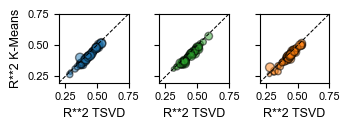

Aged Performance Correlation TSVD vs. KMeans: 
PearsonRResult(statistic=0.9736077056554269, pvalue=3.1888553972726685e-29)
n aged sessions = 45

MA Performance Correlation TSVD vs. KMeans: 
PearsonRResult(statistic=0.9835331126144395, pvalue=4.526881167746485e-38)
n MA sessions = 51

Young Performance Correlation TSVD vs. KMeans: 
PearsonRResult(statistic=0.9803804606157862, pvalue=4.300336871726248e-34)
n MA sessions = 48


In [25]:
'''Plot Figure S5A (Right)'''
fig, axes = plt.subplots(1, 3, figsize = (3.6,1.4), sharey=True)
#fig.suptitle('Split Maze (All K)', fontsize = 10)
rax = np.tile(ranks, (n_repeats, 1)).T.ravel()
axes[2].scatter(atsvdr2, akmeansr2, s = ak*10, label = 'Aged', c = 'C1', alpha = 0.5, edgecolor = 'k')
axes[1].scatter(matsvdr2, makmeansr2, s = mak*10, label = 'MA', c = 'C2', alpha = 0.5, edgecolor = 'k')
axes[0].scatter(ytsvdr2, ykmeansr2, s = yk*10, label = 'Young', c = 'C0', alpha = 0.5, edgecolor = 'k')

#label stuff
axes[0].set_ylabel("R**2 K-Means", fontsize = 9)
axes[0].set_xlabel("R**2 TSVD", fontsize = 9)
axes[1].set_xlabel("R**2 TSVD", fontsize = 9)
axes[2].set_xlabel("R**2 TSVD", fontsize = 9)
axes[2].set_xlim([0.2, 0.75])
axes[2].set_ylim([0.2, 0.75])
axes[1].set_xlim([0.2, 0.75])
axes[1].set_ylim([0.2, 0.75])
axes[0].set_xlim([0.2, 0.75])
axes[0].set_ylim([0.2, 0.75])
axes[0].set_yticks([0.25, 0.5, 0.75])
axes[0].set_xticks([0.25, 0.5, 0.75])
axes[1].set_xticks([0.25, 0.5, 0.75])
axes[2].set_xticks([0.25, 0.5, 0.75])
axes[0].tick_params(labelsize = 8)
axes[1].tick_params(labelsize = 8)
axes[2].tick_params(labelsize = 8)

#plot unity lines
xlims = axes[0].get_xlim()
ylims = axes[0].get_ylim()
min_plot = np.min([xlims[0], ylims[0]])
max_plot = np.max([xlims[1], ylims[1]])
axes[0].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
axes[1].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
axes[2].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
#axes[0].legend()
#axes[1].legend()
#axes[2].legend()
#axes[1].set_title('Dot Size ~ Optimal K (1-4)')
plt.tight_layout()

#fig.savefig(save_folder + '_tsvdvsKmeanssplit.svg', dpi = 400)
#fig.savefig(save_folder + '_tsvdvsKmeanssplit.png', dpi = 400)
plt.show()

print('Aged Performance Correlation TSVD vs. KMeans: ')
print(stats.pearsonr(atsvdr2,akmeansr2))
print('n aged sessions = ' + str(len(atsvdr2)))
print('\nMA Performance Correlation TSVD vs. KMeans: ')
print(stats.pearsonr(matsvdr2,makmeansr2))
print('n MA sessions = ' + str(len(matsvdr2)))
print('\nYoung Performance Correlation TSVD vs. KMeans: ')
print(stats.pearsonr(ytsvdr2,ykmeansr2))
print('n MA sessions = ' + str(len(ytsvdr2)))

# Re-label K-Means maps non-arbitrarily & examine alignment across vs. within map similarity.

In [26]:
''' Re-label spatial maps based on occupancy of Context A & B

 - If k = 2, map 0 is the map with the greatest relative number of trials in Block A (map 1 is the other)
 - If k = 3, map 0 & map 1 are the maps with greatest relative number of trials in Blocks A & B (map 2 is the other map)
 - If k = 4, map 0 & map 1 are the maps with greatest relative number of trials in Blocks A & B; between the remaining maps,
 whichever occupies more of blocks + A' is map 2. 
 
'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]     
        
        if len(spatialcells) > 10: 
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRbackidx = d['VRbackidx'].astype(int)
            trials = skippedrawtrialfil[VRbackidx]

            #assign map 0 to be the one dominating A, map 1 is the other map
            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                # get map indices
                map_idx = W[:, 0].astype(bool)
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    if map_idx[i]:
                        map0_idx[trials == t] = 1
                    else:
                        map1_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)

                # get assign map 0 to be the one with the greate number of trials in Context A
                trials_0inA = np.sum(np.unique(trials[map0_idx]) < 80)
                trials_1inA = np.sum(np.unique(trials[map1_idx]) < 80) 

                if trials_0inA < trials_1inA: # swap labels
                    d['map0_idx'] = 1
                else:
                    d['map0_idx'] = 0
            
            #ditto, assign map 1 to be the one dominating B, map 2 is the other map
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                map2_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    map_idx = np.where(W[i,:] == 1)[0][0]
                    if map_idx == 0:
                        map0_idx[trials == t] = 1
                    elif map_idx == 1:
                        map1_idx[trials == t] = 1
                    else:
                        map2_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)
                map2_idx = map2_idx.astype(bool)
                
                # get assign map 0 to be the one with the greate number of trials in Context A
                map0trials = np.unique(trials[map0_idx])
                map1trials = np.unique(trials[map1_idx])
                map2trials = np.unique(trials[map2_idx])
                                       
                trials_0inA = np.sum(map0trials < 80)
                trials_1inA = np.sum(map1trials < 80) 
                trials_2inA = np.sum(map2trials < 80) 
                
                d['map0_idx'] = np.argmax([trials_0inA, trials_1inA, trials_2inA])
                
                # get assign map 1 to be the one with the greate number of trials in Context B
                trials_0inB = len(map0trials[(map0trials >= 80) & (map0trials < 140)])
                trials_1inB = len(map1trials[(map1trials >= 80) & (map1trials < 140)])
                trials_2inB = len(map2trials[(map2trials >= 80) & (map2trials < 140)])

                d['map1_idx'] = np.argmax([trials_0inB, trials_1inB, trials_2inB])
                d['map2_idx'] = np.setdiff1d([0,1,2], [d['map0_idx'], d['map1_idx']])[0]
 
            #ditto but map 2 is the map occupying most of A' map 3 is the other map        
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                map2_idx = np.zeros_like(trials)
                map3_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    map_idx = np.where(W[i,:] == 1)[0][0]
                    if map_idx == 0:
                        map0_idx[trials == t] = 1
                    elif map_idx == 1:
                        map1_idx[trials == t] = 1
                    elif map_idx == 2:
                        map2_idx[trials == t] = 1
                    else:
                        map3_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)
                map2_idx = map2_idx.astype(bool)
                map3_idx = map3_idx.astype(bool)
                
                # get assign map 0 to be the one with the greate number of trials in Context A
                map0trials = np.unique(trials[map0_idx])
                map1trials = np.unique(trials[map1_idx])
                map2trials = np.unique(trials[map2_idx])
                map3trials = np.unique(trials[map3_idx])
                
                maptrials = [map0trials, map1trials, map2trials, map3trials]
                                       
                trials_0inA = np.sum(map0trials < 80)
                trials_1inA = np.sum(map1trials < 80) 
                trials_2inA = np.sum(map2trials < 80)
                trials_3inA = np.sum(map3trials < 80)
                
                d['map0_idx'] = np.argmax([trials_0inA, trials_1inA, trials_2inA, trials_3inA])
                
                # get assign map 1 to be the one with the greate number of trials in Context B
                trials_0inB = len(map0trials[(map0trials >= 80) & (map0trials < 140)])
                trials_1inB = len(map1trials[(map1trials >= 80) & (map1trials < 140)])
                trials_2inB = len(map2trials[(map2trials >= 80) & (map2trials < 140)])
                trials_3inB = len(map3trials[(map3trials >= 80) & (map3trials < 140)])
                   
                d['map1_idx'] = np.argmax([trials_0inB, trials_1inB, trials_2inB, trials_3inB])    
                
                #decide which map has more trials before half way point in alternation, that is map 2
                possibleidxs = np.setdiff1d([0,1,2,3], [d['map0_idx'], d['map1_idx']])
                lengths = []
                for n in possibleidxs:
                    althalf = np.max(np.unique(trials)//4) + 140
                    lengths = np.append(lengths, len(maptrials[n][maptrials[n] < althalf]))
                                        
                if lengths[0] > lengths[1]:           
                    d['map2_idx'] = possibleidxs[0]
                    d['map3_idx'] = possibleidxs[1]
                else:
                    d['map2_idx'] = possibleidxs[1]
                    d['map3_idx'] = possibleidxs[0]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
'''Compute within vs. across map similarity for k ≥ 2 sessions '''
saged_within = []
saged_across = []
syoung_within = []
syoung_across = []
sMA_within = []
sMA_across = []

countaged = 0
countMA = 0
countyoung = 0

allacross = []
allwithin = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10: 
            
            sim = d['spatialsimilaritybacksorted']
            W = d['kmeans']['W']

            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                
                # split by trial
                map_0 = W[:, d['map0_idx']].astype(bool)
                sim_0 = sim[map_0, :]
                sim_0 = sim_0[:, map_0]
                sim_1 = sim[~map_0, :]
                sim_1 = sim_1[:, ~map_0]
                sim_across = sim[map_0, :]
                sim_across = sim_across[:, ~map_0]

                # calculate the average similarity within vs. across maps
                within = np.append(sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                   sim_1[np.triu_indices(n=sim_1.shape[0], k=1)])
                avg_within = np.mean(within)
                across = sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])]
                avg_across = np.mean(across)

                if m in SM_aged_mice:
                    countaged += 1
                    saged_within = np.append(saged_within, avg_within)
                    saged_across = np.append(saged_across, avg_across)
                elif m in SM_MA_mice:
                    countMA += 1
                    sMA_within = np.append(sMA_within, avg_within)
                    sMA_across = np.append(sMA_across, avg_across)
                else: 
                    countyoung += 1
                    syoung_within = np.append(syoung_within, avg_within)
                    syoung_across = np.append(syoung_across, avg_across)
                
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                # split by trial
                map_0 = W[:, d['map0_idx']].astype(bool)
                map_1 = W[:, d['map1_idx']].astype(bool)
                map_2 = W[:, d['map2_idx']].astype(bool)
                
                sim_0 = sim[map_0, :]
                sim_0 = sim_0[:, map_0]
                sim_1 = sim[map_1, :]
                sim_1 = sim_1[:, map_1]
                sim_2 = sim[map_2, :]
                sim_2 = sim_2[:, map_2]
                
                sim_across = sim[map_0, :]
                sim_across = sim_across[:, map_1]
                sim_across1 = sim[map_0, :]
                sim_across1 = sim_across1[:, map_2]
                sim_across2 = sim[map_1, :]
                sim_across2 = sim_across2[:, map_2]

                # calculate the average similarity within vs. across maps
                within = np.concatenate((sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                   sim_1[np.triu_indices(n=sim_1.shape[0], k=1)],
                                   sim_2[np.triu_indices(n=sim_2.shape[0], k=1)]))
                avg_within = np.mean(within)
                
                across = np.concatenate((sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])],
                                   sim_across1[np.triu_indices(n=sim_across1.shape[0], k=1, m=sim_across1.shape[1])],
                                   sim_across2[np.triu_indices(n=sim_across2.shape[0], k=1, m=sim_across2.shape[1])]))
                avg_across = np.mean(across)
                

                if m in SM_aged_mice:
                    countaged += 1
                    saged_within = np.append(saged_within, avg_within)
                    saged_across = np.append(saged_across, avg_across)
                elif m in SM_MA_mice:
                    countMA += 1
                    sMA_within = np.append(sMA_within, avg_within)
                    sMA_across = np.append(sMA_across, avg_across)
                else: 
                    countyoung += 1
                    syoung_within = np.append(syoung_within, avg_within)
                    syoung_across = np.append(syoung_across, avg_across)
            
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                # split by trial
                map_0 = W[:, d['map0_idx']].astype(bool)
                map_1 = W[:, d['map1_idx']].astype(bool)
                map_2 = W[:, d['map2_idx']].astype(bool)
                map_3 = W[:, d['map3_idx']].astype(bool)
                
                sim_0 = sim[map_0, :]
                sim_0 = sim_0[:, map_0]
                sim_1 = sim[map_1, :]
                sim_1 = sim_1[:, map_1]
                sim_2 = sim[map_2, :]
                sim_2 = sim_2[:, map_2]
                sim_3 = sim[map_3, :]
                sim_3 = sim_3[:, map_3]
                
                sim_across = sim[map_0, :]
                sim_across = sim_across[:, map_1]
                sim_across1 = sim[map_0, :]
                sim_across1 = sim_across1[:, map_2]
                sim_across2 = sim[map_0, :]
                sim_across2 = sim_across2[:, map_3]
                sim_across3 = sim[map_1, :]
                sim_across3 = sim_across3[:, map_2]
                sim_across4 = sim[map_1, :]
                sim_across4 = sim_across4[:, map_3]
                sim_across5 = sim[map_2, :]
                sim_across5 = sim_across5[:, map_3]

                # calculate the average similarity within vs. across maps
                within = np.concatenate((sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                   sim_1[np.triu_indices(n=sim_1.shape[0], k=1)],
                                   sim_2[np.triu_indices(n=sim_2.shape[0], k=1)],
                                   sim_3[np.triu_indices(n=sim_3.shape[0], k=1)]))
                avg_within = np.mean(within)
                
                across = np.concatenate((sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])],
                                   sim_across1[np.triu_indices(n=sim_across1.shape[0], k=1, m=sim_across1.shape[1])],
                                   sim_across2[np.triu_indices(n=sim_across2.shape[0], k=1, m=sim_across2.shape[1])],
                                   sim_across3[np.triu_indices(n=sim_across3.shape[0], k=1, m=sim_across3.shape[1])],
                                   sim_across4[np.triu_indices(n=sim_across4.shape[0], k=1, m=sim_across4.shape[1])],
                                   sim_across5[np.triu_indices(n=sim_across5.shape[0], k=1, m=sim_across5.shape[1])]))
                
                avg_across = np.mean(across)


                if m in SM_aged_mice:
                    countaged += 1
                    saged_within = np.append(saged_within, avg_within)
                    saged_across = np.append(saged_across, avg_across)
                elif m in SM_MA_mice:
                    countMA += 1
                    sMA_within = np.append(sMA_within, avg_within)
                    sMA_across = np.append(sMA_across, avg_across)
                else: 
                    countyoung += 1
                    syoung_within = np.append(syoung_within, avg_within)
                    syoung_across = np.append(syoung_across, avg_across)    
            else: #one map sessions
                pass
                
print(countyoung, countMA, countaged)

47 46 41


In [28]:
'''In all age groups, are maps more similar to themselves vs. the other map?'''
# % change in aged spatial similarity
d_sima = ((saged_across - saged_within) / saged_within) * 100
print('mean, sem within map similarity: {}, {}'.format(np.round(np.mean(saged_within), 2), np.round(stats.sem(saged_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.nanmean(saged_across), 2), np.round(stats.sem(saged_across,  nan_policy = 'omit'), 2)))
print('pct change in spatial similarity (mean, sem) aged: {}, {}%'.format(np.round(np.nanmean(d_sima), 2), np.round(stats.sem(d_sima, nan_policy = 'omit'), 2)))

# % change in MA spatial similarity
d_simma = ((sMA_across - sMA_within) / sMA_within) * 100
print('\nmean, sem within map similarity: {}, {}'.format(np.round(np.mean(sMA_within), 2), np.round(stats.sem(sMA_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.mean(sMA_across), 2), np.round(stats.sem(sMA_across), 2)))
print('pct change in spatial similarity (mean, sem) MA: {}, {}%'.format(np.round(np.mean(d_simma), 2), np.round(stats.sem(d_simma), 2)))

# % change in young spatial similarity
d_simy = ((syoung_across - syoung_within) / syoung_within) * 100
print('\nmean, sem within map similarity: {}, {}'.format(np.round(np.mean(syoung_within), 2), np.round(stats.sem(syoung_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.mean(syoung_across), 2), np.round(stats.sem(syoung_across), 2)))
print('pct change in spatial similarity (mean, sem) young: {}, {}%'.format(np.round(np.mean(d_simy), 2), np.round(stats.sem(d_simy), 2)))

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(saged_within[~np.isnan(saged_across)], saged_across[~np.isnan(saged_across)])
print('\nwithin map vs across map similarity: aged_p = ' + str(sameVSdiff_p))
print('n = ' + str(saged_within.shape[0]) + ' model pairs')

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(sMA_within, sMA_across)
print('\nwithin map vs across map similarity: MA_p = ' + str(sameVSdiff_p))
print('n = ' + str(sMA_within.shape[0]) + ' model pairs')

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(syoung_within, syoung_across)
print('\nwithin map vs across map similarity: young_p = ' + str(sameVSdiff_p))
print('n = ' + str(syoung_within.shape[0]) + ' model pairs')

mean, sem within map similarity: 0.44, 0.02
mean, sem across map similarity: 0.22, 0.01
pct change in spatial similarity (mean, sem) aged: -49.48, 2.17%

mean, sem within map similarity: 0.46, 0.01
mean, sem across map similarity: 0.24, 0.02
pct change in spatial similarity (mean, sem) MA: -48.14, 2.52%

mean, sem within map similarity: 0.43, 0.02
mean, sem across map similarity: 0.19, 0.01
pct change in spatial similarity (mean, sem) young: -53.78, 2.42%

within map vs across map similarity: aged_p = 9.094947017729282e-13
n = 41 model pairs

within map vs across map similarity: MA_p = 2.842170943040401e-14
n = 46 model pairs

within map vs across map similarity: young_p = 1.4210854715202004e-14
n = 47 model pairs


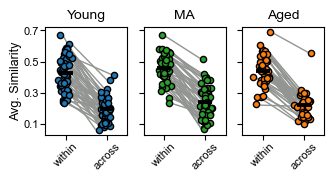

In [29]:
'''Plot Figure S5B (right)'''
f, ax = plt.subplots(1, 3, figsize=(3.6, 1.4), sharey = True)
#f.suptitle('Split Maze (k ≥ 2)', fontsize = 10)
DOT_SIZE = 20
DOT_LW = 1
BAR_SIZE = 10
BAR_WIDTH = 2.8
labels = ['within', 'across']

## PLOT AGED DATA 
j = np.random.randn(saged_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(saged_within): # plot connector lines
    a = saged_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[2].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[2].scatter(np.full(len(saged_within), 1)+j, saged_within,
           facecolors='C1', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='Aged') 

# across map similarity
ax[2].scatter(np.full(len(saged_within), 2)+j, saged_across,
           facecolors='C1', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label = 'Aged') 

# plot means
ax[2].plot(1, np.mean(saged_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[2].plot(2, np.mean(saged_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

## PLOT MA DATA 
j = np.random.randn(sMA_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(sMA_within): # plot connector lines
    a = sMA_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[1].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[1].scatter(np.full(len(sMA_within), 1)+j, sMA_within,
           facecolors='C2', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='MA') 

# across map similarity
ax[1].scatter(np.full(len(sMA_within), 2)+j, sMA_across,
           facecolors='C2', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2) 

# plot means
ax[1].plot(1, np.mean(sMA_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[1].plot(2, np.mean(sMA_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

## PLOT Young DATA 
j = np.random.randn(syoung_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(syoung_within): # plot connector lines
    a = syoung_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[0].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[0].scatter(np.full(len(syoung_within), 1)+j, syoung_within,
           facecolors='C0', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='Young') 

# across map similarity
ax[0].scatter(np.full(len(syoung_within), 2)+j, syoung_across,
           facecolors='C0', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2) 

# plot means
ax[0].plot(1, np.mean(syoung_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[0].plot(2, np.mean(syoung_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

ax[2].set_xlim([0.5, 2.5])
ax[2].set_xticks([1, 2])
ax[2].set_yticks([0.1, 0.3, 0.5, 0.7])
ax[2].set_xticklabels(labels, rotation=45)
ax[2].tick_params(which='major', labelsize=8, pad=0.8)
ax[2].set_title('Aged', fontsize = 10)

ax[1].set_xlim([0.5, 2.5])
ax[1].set_xticks([1, 2])
ax[1].set_yticks([0.1, 0.3, 0.5, 0.7])
ax[1].set_xticklabels(labels, rotation=45)
ax[1].tick_params(which='major', labelsize=8, pad=0.8)
#ax[1].set_ylabel('Avg. Correlation', fontsize=10, labelpad=1)
ax[1].set_title('MA', fontsize = 10)

ax[0].set_xlim([0.5, 2.5])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(labels, rotation=45)
ax[0].tick_params(which='major', labelsize=8, pad=0.8)
ax[0].set_title('Young', fontsize = 10)
ax[0].set_ylabel('Avg. Similarity', fontsize=9, labelpad=1)
#f.savefig(save_folder + 'similarity_k=2,3,4.png', dpi=400, bbox_inches='tight')
#f.savefig(save_folder + 'similarity_k=2,3,4.svg', dpi=400, bbox_inches='tight')
plt.show()

In [30]:
''' Statistics to Compare Age Groups Within, Across, Diff (Within - Across) Similarity'''

print('WITHIN RESULTS')
print('withinyoung ± SEM; withinMA ± SEM; withinstab_old ± SEM')
print(str(np.round(np.nanmean(syoung_within), 4)) + ' ± ' + str(np.round(stats.sem(syoung_within), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sMA_within), 4)) + ' ± ' + str(np.round(stats.sem(sMA_within), 4)) + ' ; ' 
      + str(np.round(np.nanmean(saged_within), 4)) + ' ± ' + str(np.round(stats.sem(saged_within), 4)))

stat, p_diff = stats.kruskal(syoung_within, sMA_within, saged_within)
print('stat = ' + str(stat))
print('p_grid_session = ' + str(p_diff))
stat, p_diff = stats.ranksums(syoung_within, saged_within)
print('stat = ' + str(stat))
print('p_grid_sessionyva = ' + str(p_diff))

print('\nACROSS RESULTS:')
print('acrossyoung ± SEM; acrossMA ± SEM; acrossstab_old ± SEM')
print(str(np.round(np.nanmean(syoung_across), 4)) + ' ± ' + str(np.round(stats.sem(syoung_across), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sMA_across), 4)) + ' ± ' + str(np.round(stats.sem(sMA_across), 4)) + ' ; ' 
      + str(np.round(np.nanmean(saged_across), 4)) + ' ± ' + str(np.round(stats.sem(saged_across, nan_policy = 'omit'), 4)))

stat, p_diff = stats.kruskal(syoung_across, sMA_across, saged_across)
print('stat = ' + str(stat))
print('p_grid_session = ' + str(p_diff))
stat, p_diff = stats.ranksums(syoung_across, saged_across)
print('stat = ' + str(stat))
print('p_grid_sessionyva = ' + str(p_diff))

sd_sima = ((saged_across - saged_within) / saged_within) * 100
sd_simma = ((sMA_across - sMA_within) / sMA_within) * 100
sd_simy = ((syoung_across - syoung_within) / syoung_within) * 100

print('\nWithin - Across % Change RESULTS:')
print('changeyoung ± SEM; changeMA ± SEM; changestab_old ± SEM')
print(str(np.round(np.nanmean(sd_simy), 4)) + ' ± ' + str(np.round(stats.sem(sd_simy), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sd_simma), 4)) + ' ± ' + str(np.round(stats.sem(sd_simma), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sd_sima), 4)) + ' ± ' + str(np.round(stats.sem(sd_sima, nan_policy = 'omit'), 4)))

stat, p_diff = stats.kruskal(sd_simy, sd_simma, sd_sima)
print('stat = ' + str(stat))
print('p_grid_session = ' + str(p_diff))

stat, p_diff = stats.ranksums(sd_simy, sd_sima)
print('stat = ' + str(stat))
print('p_grid_sessionyva = ' + str(p_diff))


WITHIN RESULTS
withinyoung ± SEM; withinMA ± SEM; withinstab_old ± SEM
0.4264 ± 0.0167 ; 0.4577 ± 0.0133 ; 0.4402 ± 0.0153
stat = 2.018882281357378
p_grid_session = 0.36442258363096913
stat = -0.5227990379418017
p_grid_sessionyva = 0.6011141091768346

ACROSS RESULTS:
acrossyoung ± SEM; acrossMA ± SEM; acrossstab_old ± SEM
0.1936 ± 0.0119 ; 0.2407 ± 0.0155 ; 0.2207 ± 0.0123
stat = 5.911677916757128
p_grid_session = 0.0520349870700196
stat = -1.660409744503162
p_grid_sessionyva = 0.09683205113953615

Within - Across % Change RESULTS:
changeyoung ± SEM; changeMA ± SEM; changestab_old ± SEM
-53.7819 ± 2.4193 ; -48.1438 ± 2.5203 ; -49.4836 ± 2.1684
stat = 3.772652924093734
p_grid_session = 0.15162779745717986
stat = -1.091604391222482
p_grid_sessionyva = 0.27500702517903497


This suggests that maps contain similarly heterogenous spatial information across age groups. 

In [18]:
''' Measure remapping coordination in each age group ''' 
smeancorr = []
bins = np.arange(0, 0.8, 0.05)

# adjust path to output of Fig 2/S3 Notebook where individual grid cell similarity matrices are saved.
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/crosstrial/sorted/spatial/' 

for m, session in zip(mice, sessions):
    
    m_correlation = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]   
        
        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'
        
        if len(spatialcells) > 2:
            
            allspatialsim_file = 'allspatialsim_' + m + '_' + s + '_'+ '.npy'
            allsim = np.load(save_folder + allspatialsim_file)
            
            correlation = []
            for i, c in enumerate(spatialcells):
                littlesim = allsim[:,:,i]
                allothersim = np.delete(allsim, i, axis = 2)
                sim = np.mean(allothersim, axis = 2)
                mask = np.triu_indices(sim.shape[0])
            
                #linearize upper triangles of each sim matrix
                uppersim = sim[mask]
                upperlittlesim = littlesim[mask]

                #compute correlation of front & back matrices with each other
                corr, _ = stats.pearsonr(uppersim[~np.isnan(uppersim)], upperlittlesim[~np.isnan(uppersim)])
                correlation = np.append(correlation, corr)
            
            #plot histogram of correlation values per session if you would like
            '''
            fig, ax = plt.subplots(figsize = (2,2))
            ax.hist(correlation, bins = bins, color = col)
            ax.set_title(str(m) + '_' + str(s[-1]) + ' Sim vs. CTCM Correlation', fontsize = 8)
            plt.show()
            '''
            #compute the mean for each session
            smeancorr = np.append(smeancorr, np.mean(correlation))

        else:
            print('less than three spatial cells, cannot compute mean corr for this session')
            smeancorr = np.append(smeancorr, np.nan)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

less than three spatial cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

less than three spatial cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

less than three spatial cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

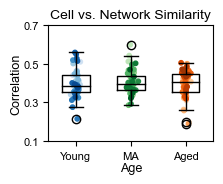

In [23]:
''' Plot Figure S5D '''

#correct plotting indices
nan_idxspatial = np.where((sperspatial == 0))[0]
y_sindspatial = np.setdiff1d(y_sind, nan_idxspatial)
ma_sindspatial = np.setdiff1d(ma_sind, nan_idxspatial)
age_sindspatial = np.setdiff1d(age_sind, nan_idxspatial)

col_sessionspatial = [col_session_young, col_session_MA, col_session_old] 

# This will fix session stats & box plots are plotted.

labels = ['Young','MA','Aged']
fig, ax = plt.subplots(1, 1, figsize=(2.125, 1.5))
w = 0.5
#f.suptitle('Spatial Cell Animal Network Similarity Matrix Correlation, Pooled by Age Group', fontsize=12)

scorr_tog = [smeancorr[y_sindspatial][~np.isnan(smeancorr[y_sindspatial])],smeancorr[ma_sindspatial][~np.isnan(smeancorr[ma_sindspatial])],smeancorr[age_sindspatial][~np.isnan(smeancorr[age_sindspatial])]]
ax.boxplot(scorr_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Cell vs. Network Similarity', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Correlation', fontsize=9, labelpad=1)
ax.set_ylim([0.1,0.70])
ax.set_yticks([0.1,0.3,0.5,0.7])

for i in range(len(scorr_tog)):
    y = scorr_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessionspatial[i][:len(y)], edgecolors = col_sessionspatial[i][:len(y)], alpha = 1, s = 10)

ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'age_meannetworksimcorr_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_meannetworksimcorr_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [24]:
''' Perform Statistics Comparing Cell vs. Network Similarity across Age Groups'''

print('\nSESSION:')
print('corryoung ± SEM; corr_MA ± SEM; corr_old ± SEM')
print(str(np.round(np.nanmean(smeancorr[y_sindspatial]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[y_sindspatial], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(smeancorr[ma_sindspatial]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[ma_sindspatial], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(smeancorr[age_sindspatial]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[age_sindspatial], nan_policy = 'omit'), 3)))

#Non-Parametric version
print('\nn young, MA, aged sessions with ≥3 spatial cells')
print(len(smeancorr[y_sindspatial][~np.isnan(smeancorr[y_sindspatial])]), len(smeancorr[ma_sindspatial][~np.isnan(smeancorr[ma_sindspatial])]),len(smeancorr[age_sindspatial][~np.isnan(smeancorr[age_sindspatial])]))

H, p = stats.kruskal(smeancorr[y_sindspatial][~np.isnan(smeancorr[y_sindspatial])],smeancorr[ma_sindspatial][~np.isnan(smeancorr[ma_sindspatial])],smeancorr[age_sindspatial][~np.isnan(smeancorr[age_sindspatial])])
print('\nKW H stat, p-value:')
print(H, p)


SESSION:
corryoung ± SEM; corr_MA ± SEM; corr_old ± SEM
0.397 ± 0.009 ; 0.406 ± 0.008 ; 0.395 ± 0.01

n young, MA, aged sessions with ≥3 spatial cells
53 57 54

KW H stat, p-value:
0.6047541480801328 0.7390593322531522


This suggest that remapping is similarly coordinated among co-recorded cells in sessions across age groups. 

However, do mice across age groups attend to the moving tower cue in the front 200 cm of the Split Maze to differentiate Context A and B to the same extent? In other words, does the grid network remap happen at the same place along the track or not across age groups? When we compare grid network remapping and map-context alignment across age groups, this will dictate whether we should use the activity along the entire track or just the back 200 cm where most of the context visual cues are.

# Compare similarity of front vs. back track grid network similarity matrices across age groups (Figure S5I-J).

Highly correlated front vs. back track similarity matrices would suggest remapping occurs in the front 200cm of the track. The less correlated these two matrices are, the more likely it is that grid remapping occurs after seeing the back 200cm of the track. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A22 012923_record2


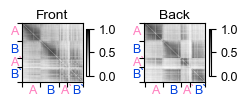

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_19708\75634341.py:72: RuntimeWarning: invalid value encountered in divide
  firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M 110422_record6


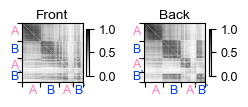

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Y22 093022_record6


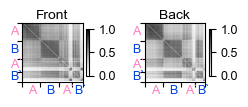

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
''' Compute Front vs. Back Track Grid Network Similarity Matrices for all Sessions, plotting Figure S5I examples along the way

Run time: ~15-30 seconds / session for 134 sessions w/ ≥ 10 grid cells

''' 

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02
grid_min = 10 
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/' #adjust save path

# if you want to plot all sessions:
#example_mice = mice
#example_sessions = sessions

# if you want to plot only example sessions from Figure S5I:
example_mice = ['Y22','MA6M','A22']
example_sessions = ['093022_record6','110422_record6','012923_record2']

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        frontonlytrials = []
        backonlytrials = []
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]   
        
        if len(spatialcells) > grid_min:
        
            posx = behaviorfil[:,0]
            trial = behaviorfil[:,2]
            rawtrialfil = raw.item().get('trialfil')

            #Find any skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                if (len(np.unique(trial)) < 220): 
                    alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
                else:    
                    alltrial = np.arange(0,220,1)
                skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
                #print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
            except: 
                skippedtrials = []
                alltrial = np.arange(0, 220, 1)

            if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
                #print(m, s)
            else:
                alltrial = np.arange(0,220,1)

            # Load in left vs. right info
            trials = np.unique(trial)
            trialinfo = raw.item().get('trialinfo')
            left = trialinfo['left']

            #sort trial labels to correspond
            posxcopy = posx.copy()
            leftsort = left.copy()
            alt_idx = 140
            lefttail = left[alt_idx:]
            lefttail = 1 - lefttail
            leftsort[alt_idx:] = lefttail[np.argsort(lefttail, kind = 'stable')]

            #revise skippedtrials locations
            allcopy = alltrial.copy()
            alltail = alltrial[alt_idx:]
            allcopy[alt_idx:] = alltail[np.argsort(lefttail, kind = 'stable')]
            newskippedtrials = []
            for z in skippedtrials:
                newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

            ndarkskipped = 0
            for z in newskippedtrials:
                if z < 20: 
                    ndarkskipped += 1

            #sort position & spike train, all copy is in the sorted order
            posxcopy = []
            allcopy = np.append(allcopy, 220)
            for t in allcopy:
                obs_idx = np.where(trial == t)[0]
                posxcopy = np.append(posxcopy, posx[obs_idx])

                if t == 0:
                    Z = Y[obs_idx,:]
                else: 
                    Z = np.append(Z, Y[obs_idx,:], axis = 0)

            #adjust trialfil so that sorted trials are skipped instead
            count = 0
            if len(skippedtrials) > 0 :
                skippedrawtrialfil = rawtrialfil.copy()
                consec = count_consec(list(np.sort(newskippedtrials).astype(int)))

                for i, k in enumerate(consec):
                    t = np.sort(newskippedtrials)[count] 
                    #print(i,t,k)

                    if i == 0: 
                        skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                    else: 
                        skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k

                    count += k
            else:
                skippedrawtrialfil = trial.copy()

            #remove dark & trial 220 dataframes     
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            if np.max(skippedrawtrialfil) == 220:
                end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            else:
                end_idx = len(skippedrawtrialfil) + 1

            #divide observations into front and back halves
            frontidx = np.where(posxcopy < 200)[0].astype(int)
            backidx = np.where(posxcopy >= 200)[0].astype(int)
            VRidx = np.arange(start_idx, end_idx, 1)
            VRfrontidx = np.intersect1d(VRidx, frontidx)
            VRbackidx = np.intersect1d(VRidx, backidx)

            frontonlytrials = np.append(frontonlytrials, np.setdiff1d(np.unique(skippedrawtrialfil[VRfrontidx]), np.unique(skippedrawtrialfil[VRbackidx])))
            frontonlyidx = []
            for t in frontonlytrials:
                frontonlyidx = np.append(frontonlyidx, np.where(np.unique(skippedrawtrialfil[VRfrontidx]) == t)[0])
            d['frontonlytrials'] = frontonlyidx

            backonlytrials = np.append(backonlytrials, np.setdiff1d(np.unique(skippedrawtrialfil[VRbackidx]), np.unique(skippedrawtrialfil[VRfrontidx])))
            backonlyidx = []
            for t in backonlytrials:
                 backonlyidx = np.append(backonlyidx, np.where(np.unique(skippedrawtrialfil[VRbackidx]) == t)[0])
            d['backonlytrials'] = backonlyidx

            #get smoothed by trial FR matrix excluding dark period sorted by context using front half of track
            normFR, _, _ = tuning_curve_bytrial(posxcopy[VRfrontidx], skippedrawtrialfil[VRfrontidx], Z[VRfrontidx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

            #get & plot similarity matrix for all spatial cells
            spatialcell = d['spatialcell99'].astype(bool)
            spatialcells = cell_IDs[spatialcell]

            sdx = []
            for i, c in enumerate(spatialcells):
                sd = (np.where(cell_IDs == c)[0][0]).astype(int)
                sdx.append(sd)

            normspatialgridFR = normFR[:,:,sdx] 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim1 = squareform(sim_vec)
            d['spatialsimilarityfront'] = sim1

            #save matrix
           # sim1_file = 'sim1_' + m + '_' + s + '_'+ '.npy'
           # np.save(save_folder + sim1_file, sim1)

            #get smoothed by trial FR matrix excluding dark period sorted by context using front half of track
            normFR, _, _ = tuning_curve_bytrial(posxcopy[VRbackidx], skippedrawtrialfil[VRbackidx], Z[VRbackidx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

            #get & plot similarity matrix for all grid cells  
            normspatialgridFR = normFR[:,:,sdx] 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim2 = squareform(sim_vec)        
            d['spatialsimilarityback'] = sim2

            #save matrix
           # sim2_file = 'sim2_' + m + '_' + s + '_'+ '.npy'
           # np.save(save_folder + sim2_file, sim2)

            #Plot front vs. back sim matrices side by side if an example session/mouse (Figure S5I)
            if (m in example_mice) and (s in example_sessions):
                print(m, s)

                # add ticks to label contexts dynamically
                colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
                labels = ['A', 'B','A`','B`']
                lengthdark = (20 - ndarkskipped)
                lengthA = len(np.unique(skippedrawtrialfil)[np.unique(skippedrawtrialfil) < (80 - lengthdark)])
                nA_ = np.sum(1 - leftsort[alltrial >= 140])
                lengthB = len(np.unique(skippedrawtrialfil)[(np.unique(skippedrawtrialfil) >= (80 - lengthdark)) & (np.unique(skippedrawtrialfil) < (140 - lengthdark))])
                lengthA_ = len(np.unique(skippedrawtrialfil)[(np.unique(skippedrawtrialfil) >= (140 - lengthdark)) & (np.unique(skippedrawtrialfil) < (140 + nA_ - lengthdark))])
                end =  sim1.shape[0]
                ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
                nB_ = end - (lengthA + lengthB + lengthA_) 
                textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

                if m in SM_aged_mice:
                    col = 'C1'
                elif m in SM_MA_mice:
                    col = 'C2'
                else:
                    col = 'C0'
                
                f, axs = plt.subplots(1,2, figsize=(2.6, 1.25))
                #f.suptitle(str(m) + '_' + str(s[-1]), fontsize = 10, color = col)
                im = axs[0].imshow(sim1, clim=[0, 1.0], aspect='auto', cmap='Greys')
                axs[0].set_title('Front'.format(m, s[-1]), fontsize=10, pad=3)
                axs[0].set_yticks(ticks, labels = [])
                axs[0].set_xticks(ticks, labels = [])
                for n, j in enumerate(labels):
                    axs[0].text(textloc[n] - 10, 240, j, color = colors[n], fontsize = 9)
                    axs[0].text(-40, textloc[n] + 10, j, color = colors[n], fontsize = 9)
                cbar = plt.colorbar(im, shrink = 0.8, ax = axs[0],ticks=np.arange(0,1.1,0.5))
                cbar.ax.tick_params(labelsize = 9)

                im = axs[1].imshow(sim2, clim=[0, 1.0], aspect='auto', cmap='Greys')
                axs[1].set_title('Back'.format(m, s[-1]), fontsize=10, pad=3)
                axs[1].set_yticks(ticks, labels = [])
                axs[1].set_xticks(ticks, labels = [])
                for n, j in enumerate(labels):
                    axs[1].text(textloc[n] - 10, 240, j, color = colors[n], fontsize = 9)
                    axs[1].text(-40, textloc[n] + 10, j, color = colors[n], fontsize = 9)
                cbar = plt.colorbar(im, shrink = 0.8, ax = axs[1],ticks=np.arange(0,1.1,0.5))
                cbar.ax.tick_params(labelsize = 9)

                plt.tight_layout()
                #f.savefig(save_folder + str(m) + '/' + str(s) + '_splitsimgridmatrices.png', dpi = 400)
                #f.savefig(save_folder + str(m) + '/' + str(s) + '_splitsimgridmatrices.svg', dpi = 400)
                plt.show()
                plt.close(f)  

In [41]:
''' Compute Magnitude of Correlation btwn Similarity Matrices '''

scorrfb = []
mcorrfb = []
spatialmultimapsesh = []

for m, session in zip(mice, sessions):
    
    m_corr = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]    
        
        if len(spatialcells) > grid_min:
            
            spatialmultimapsesh = np.append(spatialmultimapsesh, True)
            sim1 = d['spatialsimilarityfront'] 
            sim2 = d['spatialsimilarityback']
            backonlytrials = np.array(d['backonlytrials']).astype(int)
            frontonlytrials = np.array(d['frontonlytrials']).astype(int)
            
            #ensure that all matrices are the same size
            if len(backonlytrials) > 0: #remove trials from sim2 that are only in sim2
                sim2 = np.delete(np.delete(sim2, backonlytrials, 0), backonlytrials,1)
            if len(frontonlytrials) > 0: #remove trials from sim1 that are only in sim1
                sim1 = np.delete(np.delete(sim1, frontonlytrials, 0), frontonlytrials,1)
            
            #linearize upper triangles of each sim matrix
            mask = np.triu_indices(sim1.shape[0])
            uppersim1 = sim1[mask]
            uppersim2 = sim2[mask]

            #compute correlation of front & back matrices with each other
            if (np.sum(np.isnan(uppersim1)) > 0) | (np.sum(np.isnan(uppersim2)) > 0):
                spatialmultimapsesh = np.append(spatialmultimapsesh, False)
                m_corr = np.append(m_corr, np.nan)
                scorrfb = np.append(scorrfb, np.nan)
            
            else:
                spatialmultimapsesh = np.append(spatialmultimapsesh, True)
                corr, _ = stats.pearsonr(uppersim1, uppersim2)
                scorrfb = np.append(scorrfb, corr)
                m_corr = np.append(m_corr,corr)
        
        else:
            spatialmultimapsesh = np.append(spatialmultimapsesh, False)
            m_corr = np.append(m_corr, np.nan)
            scorrfb = np.append(scorrfb, np.nan)
                
        mcorrfb = np.append(mcorrfb, np.nanmean(m_corr))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_19708\4269581178.py:57: RuntimeWarning: Mean of empty slice
  mcorrfb = np.append(mcorrfb, np.nanmean(m_corr))


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

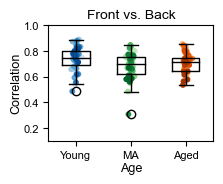

In [45]:
''' Plot Figure S5J'''

nan_idx10spatial = np.where(np.isnan(scorrfb))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind10spatial = np.setdiff1d(y_sind, nan_idx10spatial)
ma_sind10spatial = np.setdiff1d(ma_sind, nan_idx10spatial)
age_sind10spatial = np.setdiff1d(age_sind, nan_idx10spatial)

# Adjust colormaps for spatial plots
yidx = []
maidx = []
aidx = []
for i in nan_idx10spatial:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young10spatial = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma10spatial = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old10spatial = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session10spatial = [col_session_young10spatial, col_session_ma10spatial, col_session_old10spatial] 

labels = ['Young','MA','Aged']
fig, ax = plt.subplots(1, 1, figsize=(2.125, 1.5), sharey = False)
#f.suptitle('spatial Cell Session Network Similarity Matrix Correlation, Pooled by Age Group', fontsize=12)

scorr_tog = [scorrfb[y_sind10spatial],scorrfb[ma_sind10spatial],scorrfb[age_sind10spatial]]
ax.boxplot(scorr_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Front vs. Back', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.tick_params(labelsize=8)
ax.set_ylabel('Correlation', fontsize=9, labelpad=1)
ax.set_ylim([0.1,1.0])

for i in range(len(scorr_tog)):
    y = scorr_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_session10spatial[i], edgecolors = col_session10spatial[i], alpha = 1, s = 10)
    
#plt.savefig(save_folder + 'age_networksimfrontback_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_networksimfrontback_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [48]:
''' Statistically compare correlation of front vs. back spatial network similarity matrices '''

import statsmodels.api as sm
import scikit_posthocs as ph

print('Young Front vs. Back Correlation, Mean ± SEM: ')
print(str(np.mean(scorrfb[y_sind10spatial])) + ' ± ' + str(stats.sem(scorrfb[y_sind10spatial])))

print('MA Front vs. Back Correlation, Mean ± SEM: ')
print(str(np.mean(scorrfb[ma_sind10spatial])) + ' ± ' + str(stats.sem(scorrfb[ma_sind10spatial])))

print('Aged Front vs. Back Correlation, Mean ± SEM: ')
print(str(np.mean(scorrfb[age_sind10spatial])) + ' ± ' + str(stats.sem(scorrfb[age_sind10spatial])))

H, p = stats.kruskal(scorrfb[y_sind10spatial],scorrfb[ma_sind10spatial],scorrfb[age_sind10spatial])
print('\nKW H, p-value: ')
print(H, p)

#make into dataframe
sex = list(animalmeta.Sex[mice_ind])
sexes = []
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    center = rewarda_centers[np.where(mice == m)[0][0]]
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        sexes = np.append(sexes, msex)
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind10spatial,ma_sind10spatial,age_sind10spatial))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Sex = list(sexes[allidx])
Age_Group = list(seshage[allidx])
CorrFB = list(scorrfb[allidx])

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, CorrFB))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','CorrFB'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'CorrFB', group_col = 'AgeGroup', p_adjust = 'holm')

Young Front vs. Back Correlation, Mean ± SEM: 
0.7383827165132388 ± 0.012733038621161598
MA Front vs. Back Correlation, Mean ± SEM: 
0.6839591004267408 ± 0.013024028551906213
Aged Front vs. Back Correlation, Mean ± SEM: 
0.702076333363409 ± 0.011324962927093441

KW H, p-value: 
10.2435087406148 0.005965547929053889


,1.0,2.0,3.0
1.0,1.000000,0.006432,0.029717
2.0,0.006432,1.000000,0.591752
3.0,0.029717,0.591752,1.000000


# Compare heterogeneity of spatial network information in context-matched task epochs across age groups (Figure S5G-H).

Here, we use a circular position decoder to compare accuracy of position decoding score when trained/tested on spatial cell network activity from different pairs of Split Maze task epochs (e.g. Train on Block A and Test on Block A vs. Block B). If remapping is occuring between epochs, spatial network spatial information should heterogenous across epochs, resulting in better decoder performance when trained / tested on the same epoch vs. a different one. Similarly, decoders trained/tested on context-matched epochs should outperform those trained/tested on context-mismatched epochs if spatial cell network spatial information is more homogenous across context-matched epochs. The goal of this analysis was to verify these expectations about spatial cell network information content across Split Maze task epochs. 

In [61]:
''' DECODER ANALYSIS '''
import scipy.stats 
from scipy.ndimage import gaussian_filter1d
normcdf = scipy.stats.norm.cdf
normpdf = scipy.stats.norm.pdf

SMOOTHNESS = 10.0
REGULARIZATION = 1e-4

## REGRESSION MODEL ##

from scipy.linalg import cho_factor, cho_solve
from sklearn.base import BaseEstimator

class CircularRegression(BaseEstimator):
    
    def __init__(self, alpha=0.0, tol=1e-5, max_iter=100):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array
            Independent variables, has shape (n_timepoints x n_neurons)
        y : array
            Circular dependent variable, has shape (n_timepoints x 1),
            all data should lie on the interval [-pi, +pi].
        """
        
        # Convert 1d circular variable to 2d representation
        u = np.column_stack([np.sin(y), np.cos(y)])

        # Randomly initialize weights. Ensure scaling does
        W = np.random.randn(X.shape[1], 2)
        W /= np.max(np.sum(np.abs(X @ W), axis=1))
        
        # Cache neuron x neuron gram matrix. This is used below
        # in the M-step to solve a linear least squares problem
        # in the form inv(XtX) @ XtY. Add regularization term to
        # the diagonal.
        XtX = X.T @ X
        XtX[np.diag_indices_from(XtX)] += self.alpha
        XtX = cho_factor(XtX)

        # Compute model prediction in 2d space, and projection onto
        # each observed u.
        XW = (X @ W)
        t = np.sum(u * XW, axis=1)
        tcdf = normcdf(t)
        tpdf = normpdf(t)

        self.log_like_hist_ = [
            np.log(2 * np.pi) - 
            0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
            np.mean(np.log(1 + t * tcdf / tpdf))
        ]

        for itr in range(self.max_iter):

            # E-step.
            m = t + (tcdf / ((tpdf + t * tcdf)))
            XtY = X.T @ (m[:, None] * u)

            # M-step.
            W = cho_solve(XtX, XtY)
            
            # Recompute model prediction.
            XW = X @ W
            t = np.sum(u * XW, axis=1)
            tcdf = normcdf(t)
            tpdf = normpdf(t)

            # Store log-likelihood.
            self.log_like_hist_.append(
                np.log(2 * np.pi) - 
                0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
                np.mean(np.log(1 + t * tcdf / tpdf))
            )
            
            # Check convergence.
            if (self.log_like_hist_[-1] - self.log_like_hist_[-2]) < self.tol:
                break
    
        self.weights_ = W
    
    def predict(self, X):
        u_pred = X @ self.weights_
        return np.arctan2(u_pred[:, 0], u_pred[:, 1])

    def score(self, X, y):
        """
        Returns 1 minus mean angular similarity between y and model prediction.
        
        score == 1 for perfect prediction
        score == 0 in expectation for random prediction
        score == -1 if prediction is off by 180 degrees.
        """
        y_pred = self.predict(X)
        return np.mean(np.cos(y - y_pred))

In [62]:
'''Define Function to Split Train & Test Blocks'''
def train_vs_test_blocks(X, y, train_data_idx, test_data_idx, n_repeats=10, train_pct=0.9):
    test_scores = []    
    test_folds = np.array_split(test_data_idx, n_repeats)

    for i in range(n_repeats):        
        # Get train and test indices
        test_idx = test_folds[i]
        train_idx = np.random.choice(np.setdiff1d(train_data_idx, test_idx),
                                     replace=False, size=int(train_data_idx.size * train_pct))

        # Train model
        model.fit(X[train_idx], y[train_idx])

        # Compute test error
        test_scores.append(model.score(X[test_idx], y[test_idx]))
        
    return np.asarray(test_scores)

In [ ]:
''' Get X (instantaneous FR of grid cells) and y (circular position)'''

dt = 0.02
track_len = 400
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]

        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-errorcorrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            # convert spikes to instantaneous FR and smooth, then select only the grid cell data
            X = Y / dt # convert spike count to FR
            X = gaussian_filter1d(X, SMOOTHNESS, axis=0)

            sdx = []
            for i, c in enumerate(gridcells):
                sd = (np.where(cell_IDs == c)[0][0]).astype(int)
                sdx.append(sd)

            X = X[:,sdx]

            # format position s.t. 0 = -pi = +pi = 400
            y_raw = behaviorfil[:, 0]
            y = (y_raw / np.max(y_raw)) * 2 * np.pi - np.pi

            d['X'] = X
            d['y'] = y

In [ ]:
''' Downsample to Match Speed and Num Observations (A vs A')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Aidx']
            map1_idx = d['A_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [ ]:
''' Fit model on each map0 = Context A, map1 = Context A_'''

model = CircularRegression(alpha=REGULARIZATION)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            X = d['X']
            shuff_X = d['shuff_X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['AA_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
           
            AA_scores_file = 'AA_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + AA_scores_file, d['AA_scores'])

In [ ]:
''' Downsample to Match Speed and Num Observations (B vs B')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Bidx']
            map1_idx = d['B_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [ ]:
''' Fit model on each map0 = Context B, map1 = Context B_'''

model = CircularRegression(alpha=REGULARIZATION)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            X = d['X']
            shuff_X = d['shuff_X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['BB_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            BB_scores_file = 'BB_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + BB_scores_file, d['BB_scores'])

In [ ]:
''' Downsample to Match Speed and Num Observations (A vs B)'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Aidx']
            map1_idx = d['Bidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [ ]:
''' Fit model on each map0 = Context A, map1 = Context B'''

model = CircularRegression(alpha=REGULARIZATION)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            X = d['X']
            shuff_X = d['shuff_X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['ABscores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            ABscores_file = 'ABscores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + ABscores_file, d['ABscores'])

In [ ]:
''' Downsample to Match Speed and Num Observations (A_ vs B_)'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['A_ngidx']
            map1_idx = d['B_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [ ]:
''' Fit model on each map0 = Context A_, map1 = Context B_'''

model = CircularRegression(alpha=REGULARIZATION)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            X = d['X']
            shuff_X = d['shuff_X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['A_B_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            A_B_scores_file = 'A_B_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + A_B_scores_file, d['A_B_scores'])

In [ ]:
''' Downsample to Match Speed and Num Observations (B vs A')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Bidx']
            map1_idx = d['A_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [ ]:
''' Fit model on each map0 = Context B, map1 = Context A_'''

model = CircularRegression(alpha=REGULARIZATION)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            X = d['X']
            shuff_X = d['shuff_X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['BA_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            BA_scores_file = 'BA_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + BA_scores_file, d['BA_scores'])

In [ ]:
''' Downsample to Match Speed and Num Observations (A vs B')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Aidx']
            map1_idx = d['B_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [ ]:
''' Fit model on each map0 = Context A, map1 = Context B_'''

model = CircularRegression(alpha=REGULARIZATION)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            X = d['X']
            shuff_X = d['shuff_X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]
            
            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['AB_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            AB_scores_file = 'AB_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + AB_scores_file, d['AB_scores'])

In [63]:
''' Collate Results from 6x Decoder Analyses Above '''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/decoder/spatial/'

#get total number of sessions that meet criteria
count = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            count += 1

#train test same arrays
AA = np.zeros((3, count))
BB = np.zeros((3, count))
A_A_ = np.zeros((3, count))
B_B_ = np.zeros((3, count))

#train/test context-matched
AA_ = []
A_A = []
BB_ = []
B_B = []

#train/test context-mismatched
AB = []
BA = []
A_B_ = []
B_A_ = []
BA_ = []
A_B = []
AB_ = []
B_A = []

ysesh = []
masesh = []
agesesh = []

count = -1
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        if len(spatialcells) > 10:
            
            #decoder run 1 A vs. A'
            AA_scores_file = 'AA_scores_decoder_' + m + '_' + s + '.npy'
            d['AA_scores'] = np.load(save_folder + AA_scores_file) 
            scores = d['AA_scores']

            AA[0,count] = np.mean(scores[0,:])
            A_A_[0, count] =  np.mean(scores[2,:])   
            AA_ = np.append(AA_, np.mean(scores[1,:]))       
            A_A = np.append(A_A, np.mean(scores[3,:]))
            
            #decoder run 2 B vs. B'
            BB_scores_file = 'BB_scores_decoder_' + m + '_' + s + '.npy'
            d['BB_scores'] = np.load(save_folder + BB_scores_file) 
            scores = d['BB_scores']

            BB[0,count] = np.mean(scores[0,:])
            B_B_[0, count] =  np.mean(scores[2,:])   
            BB_ = np.append(BB_, np.mean(scores[1,:]))       
            B_B = np.append(B_B, np.mean(scores[3,:]))
            
            #decoder run 3 A vs. B
            ABscores_file = 'ABscores_decoder_' + m + '_' + s + '.npy'
            d['ABscores'] = np.load(save_folder + ABscores_file)
            scores = d['ABscores']
            
            AA[1,count] = np.mean(scores[0,:])
            BB[1,count] = np.mean(scores[2,:]) 
            AB = np.append(AB, np.mean(scores[1,:]))       
            BA = np.append(BA, np.mean(scores[3,:]))
            
            #decoder run 4 A' x B'
            A_B_scores_file = 'A_B_scores_decoder_' + m + '_' + s + '.npy'
            d['A_B_scores'] = np.load(save_folder + A_B_scores_file)
            scores = d['A_B_scores']
            
            A_A_[1,count] = np.mean(scores[0,:])
            B_B_[1,count] = np.mean(scores[2,:]) 
            A_B_ = np.append(A_B_, np.mean(scores[1,:]))       
            B_A_ = np.append(B_A_, np.mean(scores[3,:]))
            
            #decoder run 5 B x A'
            BA_scores_file = 'BA_scores_decoder_' + m + '_' + s + '.npy'
            d['BA_scores'] = np.load(save_folder + BA_scores_file)
            scores = d['BA_scores']
            
            BB[2,count] = np.mean(scores[0,:])
            BA_ = np.append(BA_, np.mean(scores[1,:]))
            A_A_[2,count] = np.mean(scores[2,:])
            A_B = np.append(A_B, np.mean(scores[3,:]))
            
            #decoder run 6 A x B'
            AB_scores_file = 'AB_scores_decoder_' + m + '_' + s + '.npy'
            d['AB_scores'] = np.load(save_folder + AB_scores_file)
            scores = d['AB_scores'] 
                             
            AA[2,count] = np.mean(scores[0,:])
            AB_ = np.append(AB_, np.mean(scores[1,:]))
            B_B_[2,count] = np.mean(scores[2,:])
            B_A = np.append(B_A, np.mean(scores[3,:]))
              
            count += 1
            if m in SM_aged_mice:
                agesesh = np.append(agesesh, count)
            elif m in SM_MA_mice:
                masesh = np.append(masesh, count)
            else: 
                ysesh = np.append(ysesh, count)
                
ysesh = ysesh.astype(int)
masesh = masesh.astype(int)
agesesh = agesesh.astype(int)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

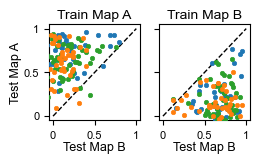

In [64]:
''' Plot Scatter of Decoder Scores Train/Test Same vs. Different Epoch (Split Maze Block Phase) (Figure S5G)'''

# plot performance same train/test vs. different train/test
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(2.6, 1.25), sharey = True) 
#f.suptitle('Decoder Performance by Train/Test Pairing & Age Group')

DOT_SIZE = 10
DOT_LW = 0.5
UNITY_WIDTH = 1
SEM_WIDTH = 0.8

avg_0to0 = np.mean(AA, axis = 0)
avg_0to1 = AB
avg_1to1 = np.mean(BB, axis = 0)
avg_1to0 = BA

# train on map 0, test on map 0 vs. test on map 1
ax0.scatter(avg_0to1[ysesh], avg_0to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')   

ax0.scatter(avg_0to1[masesh], avg_0to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')   

ax0.scatter(avg_0to1[agesesh], avg_0to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')   

# train on map 1, test on map 1 vs. test on map 0
ax1.scatter(avg_1to1[ysesh], avg_1to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')

ax1.scatter(avg_1to1[masesh], avg_1to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')  

ax1.scatter(avg_1to1[agesesh], avg_1to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')

# plot unity lines + shuffle/best lines
ax0.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)
ax1.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)

# label everything
ax0.set_title('Train Map A', fontsize=10, pad=4)
ax0.set_ylabel('Test Map A', fontsize=9, labelpad=1)
ax0.set_xlabel('Test Map B', fontsize=9, labelpad=1)
ax0.set_ylim([-0.05, 1.05])
ax0.set_xlim([-0.05, 1.05])
ax0.set_xticks([0, 0.5, 1])
ax0.set_xticklabels([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])
ax0.set_yticklabels([0, 0.5, 1])

ax1.set_title('Train Map B', fontsize=10, pad=4)
#ax1.set_ylabel('Test Map 1', fontsize=9, labelpad=1)
ax1.set_xlabel('Test Map B', fontsize=9, labelpad=1)
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlim([-0.05, 1.05])
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels([0, 0.5, 1])

ax0.tick_params(which='major', labelsize=8)
ax1.tick_params(which='major', labelsize=8)
#ax1.legend(fontsize = 8)
#ax0.legend(fontsize = 8)

#f.savefig(save_folder + 'smtrainblocktestblock_decoder_scores.png', dpi=400, bbox_inches='tight')
#f.savefig(save_folder + 'smtrainblocktestblock_decoder_scores.svg', dpi=400, bbox_inches='tight')
plt.show()

In [65]:
'''Statistical Comparison of Decoder Scores Train/Test Same vs. Different by Age Group & Together'''
allsind = np.concatenate((ysesh, masesh, agesesh))

# train/test map 0 vs. map 1 on young mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[ysesh], avg_1to1[ysesh])
print('mean ± SEM train/test A: ' + str(np.mean(avg_0to0[ysesh])) + ', ' + str(stats.sem(avg_0to0[ysesh])))
print('mean ± SEM train/test B: ' + str(np.mean(avg_1to1[ysesh])) + ', ' + str(stats.sem(avg_1to1[ysesh])))
print('YOUNG train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on MA mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[masesh], avg_1to1[masesh])
print('\nmean ± SEM train/test A: ' + str(np.mean(avg_0to0[masesh])) + ', ' + str(stats.sem(avg_0to0[masesh])))
print('mean ± SEM train/test B: ' + str(np.mean(avg_1to1[masesh])) + ', ' + str(stats.sem(avg_1to1[masesh])))
print('MA train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on aged mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[agesesh], avg_1to1[agesesh])
print('\nmean ± SEM train/test A: ' + str(np.mean(avg_0to0[agesesh])) + ', ' + str(stats.sem(avg_0to0[agesesh])))
print('mean ± SEM train/test B: ' + str(np.mean(avg_1to1[agesesh])) + ', ' + str(stats.sem(avg_1to1[agesesh])))
print('AGED train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on both age groups of mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[allsind], avg_1to1[allsind])
print('ALL train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test same map vs. other map
same_to_same = np.append(avg_0to0[ysesh], avg_1to1[ysesh])
diff_to_diff = np.append(avg_0to1[ysesh], avg_1to0[ysesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nYOUNG train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[masesh], avg_1to1[masesh])
diff_to_diff = np.append(avg_0to1[masesh], avg_1to0[masesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nMA train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[agesesh], avg_1to1[agesesh])
diff_to_diff = np.append(avg_0to1[agesesh], avg_1to0[agesesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nAGED train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[allsind], avg_1to1[allsind])
diff_to_diff = np.append(avg_0to1[allsind], avg_1to0[allsind])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nALL train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

#age group effects
stat, p = stats.kruskal(avg_0to0[ysesh],avg_0to0[masesh],avg_0to0[agesesh])
print('\nYOUNG vs. MA vs. AGED train/test map A : p = ' + str(p))

stat, p = stats.kruskal(avg_1to1[ysesh],avg_1to1[masesh],avg_1to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B: p = ' + str(p))

stat, p = stats.kruskal(avg_1to0[ysesh],avg_1to0[masesh],avg_1to0[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B/A: p = ' + str(p))

stat, p = stats.kruskal(avg_0to1[ysesh],avg_0to1[masesh],avg_0to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map A/B: p = ' + str(p))

mean ± SEM train/test A: 0.7333946382823245, 0.026727076024328267
mean ± SEM train/test B: 0.6817966266202499, 0.028657730989703513
YOUNG train/test map A vs. map B: p = 0.14886755022583809

mean ± SEM train/test A: 0.6428969679004685, 0.02548279649582509
mean ± SEM train/test B: 0.6817259645157989, 0.02187166174148363
MA train/test map A vs. map B: p = 0.26801599705244394

mean ± SEM train/test A: 0.6213841000982852, 0.031687275240460375
mean ± SEM train/test B: 0.6237999898539902, 0.03250662891595076
AGED train/test map A vs. map B: p = 0.7438018625087117
ALL train/test map A vs. map B: p = 0.8729571832661078

YOUNG train/test same vs. train/test different: p = 9.788792723651038e-18
mean ± SEM test same: 0.7075956324512873, 0.019668901168475163
mean ± SEM test diff: 0.16391475488897184, 0.02432155212628914
n = 96 model pairs

MA train/test same vs. train/test different: p = 1.6943948963546656e-18
mean ± SEM test same: 0.6623114662081337, 0.016818920674767476
mean ± SEM test diff: 0.1

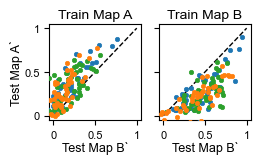

In [66]:
''' Plot Scatter of Decoder Scores Train/Test Context-Matched vs. -Mismatched (across Split Maze Block vs. Alt Phases) (Figure S5H)'''

# plot performance context-matched train/test vs. -mismatched train/test
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(2.6, 1.25), sharey = True) 
#f.suptitle('Decoder Performance by Train/Test Pairing & Age Group')

DOT_SIZE = 10
DOT_LW = 0.5
UNITY_WIDTH = 1
SEM_WIDTH = 0.8

avg_0to0 = AA_
avg_0to1 = AB_
avg_1to1 = BB_
avg_1to0 = BA_

# train on map 0, test on map 0 vs. test on map 1
ax0.scatter(avg_0to1[ysesh], avg_0to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')   

ax0.scatter(avg_0to1[masesh], avg_0to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')   

ax0.scatter(avg_0to1[agesesh], avg_0to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')   

# train on map 1, test on map 1 vs. test on map 0
ax1.scatter(avg_1to1[ysesh], avg_1to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')

ax1.scatter(avg_1to1[masesh], avg_1to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')  

ax1.scatter(avg_1to1[agesesh], avg_1to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')

# plot unity lines + shuffle/best lines
ax0.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)
ax1.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)

# label everything
ax0.set_title('Train Map A', fontsize=10, pad=4)
ax0.set_ylabel('Test Map A`', fontsize=9, labelpad=1)
ax0.set_xlabel('Test Map B`', fontsize=9, labelpad=1)
ax0.set_ylim([-0.05, 1.05])
ax0.set_xlim([-0.05, 1.05])
ax0.set_xticks([0, 0.5, 1])
ax0.set_xticklabels([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])
ax0.set_yticklabels([0, 0.5, 1])

ax1.set_title('Train Map B', fontsize=10, pad=4)
#ax1.set_ylabel('Test Map 1', fontsize=9, labelpad=1)
ax1.set_xlabel('Test Map B`', fontsize=9, labelpad=1)
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlim([-0.05, 1.05])
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels([0, 0.5, 1])

ax0.tick_params(which='major', labelsize=8)
ax1.tick_params(which='major', labelsize=8)
#ax1.legend(fontsize = 8)
#ax0.legend(fontsize = 8)

#f.savefig(save_folder + 'smtrainblockktestalt_decoder_scores.png', dpi=400, bbox_inches='tight')
#f.savefig(save_folder + 'smtrainblocktestalt_decoder_scores.svg', dpi=400, bbox_inches='tight')
plt.show()

In [68]:
'''Statistical Comparison of Decoder Scores Train/Test Context-Matched vs. -Mismatched by Age Group & Together'''
allsind = np.concatenate((ysesh, masesh, agesesh))

# train/test map 0 vs. map 1 on young mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[ysesh], avg_1to1[ysesh])
print('mean ± SEM train/test AA: ' + str(np.mean(avg_0to0[ysesh])) + ', ' + str(stats.sem(avg_0to0[ysesh])))
print('mean ± SEM train/test BB: ' + str(np.mean(avg_1to1[ysesh])) + ', ' + str(stats.sem(avg_1to1[ysesh])))
print('YOUNG train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on MA mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[masesh], avg_1to1[masesh])
print('\nmean ± SEM train/test AA: ' + str(np.mean(avg_0to0[masesh])) + ', ' + str(stats.sem(avg_0to0[masesh])))
print('mean ± SEM train/test BB: ' + str(np.mean(avg_1to1[masesh])) + ', ' + str(stats.sem(avg_1to1[masesh])))
print('MA train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on aged mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[agesesh], avg_1to1[agesesh])
print('\nmean ± SEM train/test AA: ' + str(np.mean(avg_0to0[agesesh])) + ', ' + str(stats.sem(avg_0to0[agesesh])))
print('mean ± SEM train/test BB: ' + str(np.mean(avg_1to1[agesesh])) + ', ' + str(stats.sem(avg_1to1[agesesh])))
print('AGED train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on both age groups of mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[allsind], avg_1to1[allsind])
print('ALL train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test same map vs. other map
same_to_same = np.append(avg_0to0[ysesh], avg_1to1[ysesh])
diff_to_diff = np.append(avg_0to1[ysesh], avg_1to0[ysesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nYOUNG train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[masesh], avg_1to1[masesh])
diff_to_diff = np.append(avg_0to1[masesh], avg_1to0[masesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nMA train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[agesesh], avg_1to1[agesesh])
diff_to_diff = np.append(avg_0to1[agesesh], avg_1to0[agesesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nAGED train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[allsind], avg_1to1[allsind])
diff_to_diff = np.append(avg_0to1[allsind], avg_1to0[allsind])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nALL train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

#age group effects
stat, p = stats.kruskal(avg_0to0[ysesh],avg_0to0[masesh],avg_0to0[agesesh])
print('\nYOUNG vs. MA vs. AGED train/test map A/A` : p = ' + str(p))

stat, p = stats.kruskal(avg_1to1[ysesh],avg_1to1[masesh],avg_1to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B/B`: p = ' + str(p))

stat, p = stats.kruskal(avg_1to0[ysesh],avg_1to0[masesh],avg_1to0[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B/A`: p = ' + str(p))

stat, p = stats.kruskal(avg_0to1[ysesh],avg_0to1[masesh],avg_0to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map A/B`: p = ' + str(p))

mean ± SEM train/test AA: 0.30535896538133833, 0.03693236425389361
mean ± SEM train/test BB: 0.46304368938647017, 0.03185955521462405
YOUNG train/test matched AA` vs. BB`: p = 0.0021386041400707134

mean ± SEM train/test AA: 0.3269240733347771, 0.02656377730282374
mean ± SEM train/test BB: 0.4915892782138817, 0.02386961175871705
MA train/test matched AA` vs. BB`: p = 3.189204295205788e-05

mean ± SEM train/test AA: 0.2833660312316037, 0.028443219695384468
mean ± SEM train/test BB: 0.42252060463922675, 0.03322174411795243
AGED train/test matched AA` vs. BB`: p = 0.001625910743129389
ALL train/test matched AA` vs. BB`: p = 2.432106154912385e-09

YOUNG train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = 2.7118940686568294e-16
mean ± SEM test same: 0.3842013273839042, 0.02557205332322535
mean ± SEM test diff: 0.22063518508090793, 0.023293640361748677
n = 96 model pairs

MA train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = 1.867898023463604e-16
mean ± SEM t